In [2]:
import sys
if sys.version_info[0] < 3:
	raise Exception("Python 3 not detected.")
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from scipy import io

if __name__ == "__main__":
    for data_name in ["mnist", "spam"]:
        data = np.load(f"../data/{data_name}-data-hw3.npz")
        print("\nloaded %s data!" % data_name)
        fields = "test_data", "training_data", "training_labels"
        for field in fields:
            print(field, data[field].shape)


loaded mnist data!
test_data (10000, 1, 28, 28)
training_data (60000, 1, 28, 28)
training_labels (60000,)

loaded spam data!
test_data (1000, 32)
training_data (4171, 32)
training_labels (4171,)


In [2]:
data = np.load("../data/mnist-data-hw3.npz")
mnist_data = data['training_data']
master_mnist_data = mnist_data.reshape(len(mnist_data), -1)
master_mnist_data.shape

(60000, 784)

In [3]:
data['training_data'].shape

(60000, 1, 28, 28)

# Question 1

In [4]:
#Normalize pixel images
#master_mnist_data = master_mnist_data/np.linalg.norm(master_mnist_data, axis = 1, ord = 2)[:,None]
master_mnist_data = master_mnist_data/np.linalg.norm(master_mnist_data, axis = 1, ord = 2, keepdims=True)

In [5]:
means = {}
covariances = {}
for digit in range(0, 10):
    arg_digit = np.where(data['training_labels'] == digit)[0]
    covariances[digit] = np.cov(master_mnist_data[arg_digit], rowvar=False)
    means[digit] = np.mean(master_mnist_data[arg_digit], axis = 0)

In [6]:
for c in range(0,10):
    print("Mean for ", c, " ", np.sum(means[c]))
    print("Covariance numpy for ", c, " ", np.sum(covariances[c]))
    print()

Mean for  0   12.432536740342695
Covariance numpy for  0   1.712832066775244

Mean for  1   8.260688490951557
Covariance numpy for  1   1.0845252760343553

Mean for  2   11.59429059480188
Covariance numpy for  2   1.7278970006952639

Mean for  3   11.322561400864416
Covariance numpy for  3   1.814784005874946

Mean for  4   10.52704836617659
Covariance numpy for  4   1.4150021138467517

Mean for  5   10.879231294369088
Covariance numpy for  5   1.8709201496120993

Mean for  6   11.159729078485272
Covariance numpy for  6   1.758935857367471

Mean for  7   10.171000318639829
Covariance numpy for  7   1.3905718877629827

Mean for  8   11.689119392255398
Covariance numpy for  8   1.6447373418619775

Mean for  9   10.587645888004307
Covariance numpy for  9   1.406135815939539



# Question 2

Text(0.5, 1.0, 'Covariance Matrix for Digit 2')

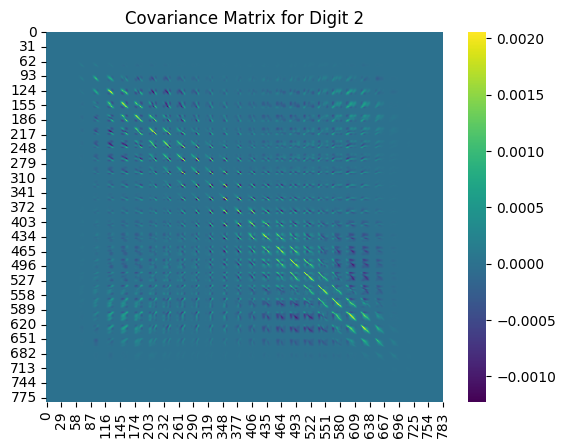

In [7]:
import seaborn as sns
sns.heatmap(covariances[2], cmap = 'viridis')
plt.title('Covariance Matrix for Digit 2')

The diagonal terms seem to have higher covariance values suggesting that the variances of values is higher then then covariances of values with other values.

# Question 3a

In [8]:
import scipy
from sklearn.model_selection import train_test_split

data = np.load("../data/mnist-data-hw3.npz")
mnist_data = data['training_data']
master_mnist_data = mnist_data.reshape(len(mnist_data), -1)
master_mnist_data.shape
master_mnist_data = master_mnist_data/np.linalg.norm(master_mnist_data, axis = 1, ord = 2, keepdims=True)

def LDA_QDA_train_valid(lamb, training_amount=None):
    size = 10000/len(data['training_labels'])

    X_train, X_test, y_train, y_test = train_test_split(master_mnist_data, data['training_labels'], test_size=size, random_state=42)

    X_train = X_train[:training_amount]
    y_train = y_train[:training_amount]

    means = {}
    covariances = {}
    for digit in range(0, 10):
        arg_digit = np.where(y_train == digit)[0]
        covariances[digit] = np.cov(X_train[arg_digit], rowvar=False)
        means[digit] = np.mean(X_train[arg_digit], axis = 0)

    
    pooled_covariance = 0
    for digit in range(0,10):
        arg_digit = np.where(y_train == digit)[0]
        pooled_covariance += (covariances[digit] * len(arg_digit))

    pooled_covariance = pooled_covariance/len(y_train)
    pooled_covariance_changed = pooled_covariance + lamb*np.identity(len(pooled_covariance))

    multi_LDA = {}
    for digit in range(10):
        arg_digit = np.where(y_train == digit)[0]
        multi_LDA[digit] = scipy.stats.multivariate_normal.logpdf(x = X_test, mean = means[digit], cov = pooled_covariance_changed, allow_singular=True) + np.log(len(arg_digit)/len(y_train))
    
    f_LDA = np.array(list(multi_LDA.values()))
    ans_LDA = np.argmax(f_LDA, axis = 0)
    error_score_LDA = 1 - (sum(ans_LDA == y_test)/len(y_test))

    for digit in range(10):
        covariances[digit] = covariances[digit] + lamb*np.identity(len(covariances[digit]))

    multi_QDA = {}
    for digit in range(10):
        arg_digit = np.where(y_train == digit)[0]
        multi_QDA[digit] = scipy.stats.multivariate_normal.logpdf(x = X_test, mean = means[digit], cov = covariances[digit], allow_singular=True) + np.log(len(arg_digit)/len(y_train))
    
    f_QDA = np.array(list(multi_QDA.values()))
    ans_QDA = np.argmax(f_QDA, axis = 0)
    error_score_QDA = 1 - (sum(ans_QDA == y_test)/len(y_test))


    #Question 3d
    digit_error_rate_LDA = [0]*10
    inds = [i for i, x in enumerate(ans_LDA == y_test) if x == False]
    for i in inds:
        digit_error_rate_LDA[y_test[i]] += 1
    digit_error_rate_LDA = [digit_error_rate_LDA[x] / sum(y_test == x) for x in range(len(digit_error_rate_LDA))]
    

    digit_error_rate_QDA = [0]*10
    inds = [i for i, x in enumerate(ans_QDA == y_test) if x == False]
    for i in inds:
        digit_error_rate_QDA[y_test[i]] += 1
    digit_error_rate_QDA = [digit_error_rate_QDA[x] / sum(y_test == x) for x in range(len(digit_error_rate_LDA))]

    return {'LDA':multi_LDA, 'QDA':multi_QDA, 'Error_Scores':(error_score_LDA, error_score_QDA), 'Digit_Errors':(digit_error_rate_LDA, digit_error_rate_QDA)}
    

In [9]:
training_100 = LDA_QDA_train_valid(0.001, 100)
training_200 = LDA_QDA_train_valid(0.0001, 200)
training_500 = LDA_QDA_train_valid(0.001, 500)
training_1000 = LDA_QDA_train_valid(0.001, 1000)
training_2000 = LDA_QDA_train_valid(0.001, 2000)
training_5000 = LDA_QDA_train_valid(0.001, 5000)
training_10000 = LDA_QDA_train_valid(0.001, 10000)
training_30000 = LDA_QDA_train_valid(0.001, 30000)
training_50000 = LDA_QDA_train_valid(0.001, 50000)

# Question 3b

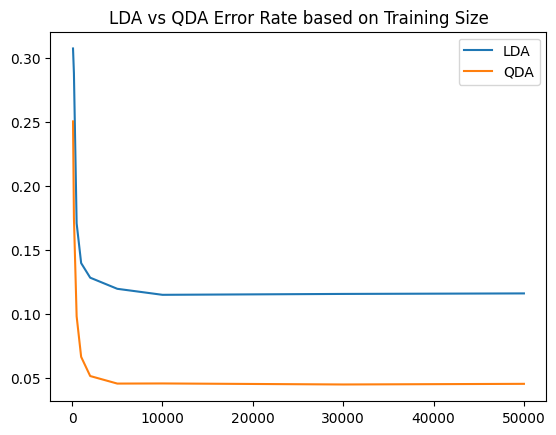

In [10]:
plt.plot([100,200,500,1000,2000,5000,10000,30000,50000],  [training_100['Error_Scores'], training_200['Error_Scores'],training_500['Error_Scores'],training_1000['Error_Scores'],training_2000['Error_Scores'],training_5000['Error_Scores'],training_10000['Error_Scores'],training_30000['Error_Scores'],training_50000['Error_Scores']], label = ['LDA', 'QDA'])
plt.title('LDA vs QDA Error Rate based on Training Size')
plt.legend()

# Question 3d

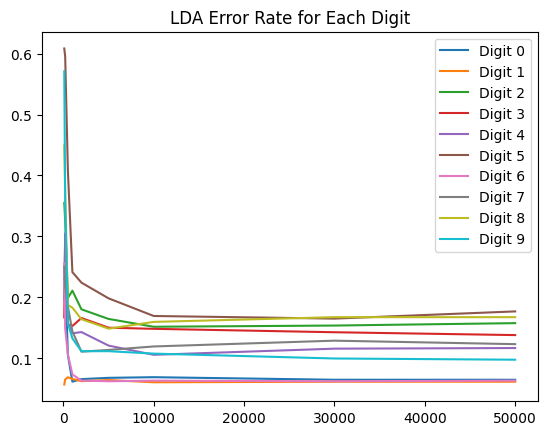

In [11]:
plt.plot([100,200,500,1000,2000,5000,10000,30000,50000],  [training_100['Digit_Errors'][0], training_200['Digit_Errors'][0],training_500['Digit_Errors'][0],training_1000['Digit_Errors'][0],training_2000['Digit_Errors'][0],training_5000['Digit_Errors'][0],training_10000['Digit_Errors'][0],training_30000['Digit_Errors'][0],training_50000['Digit_Errors'][0]], label = ['Digit 0','Digit 1', 'Digit 2', 'Digit 3', 'Digit 4', 'Digit 5', 'Digit 6', 'Digit 7', 'Digit 8', 'Digit 9'])
plt.title('LDA Error Rate for Each Digit')
plt.legend()

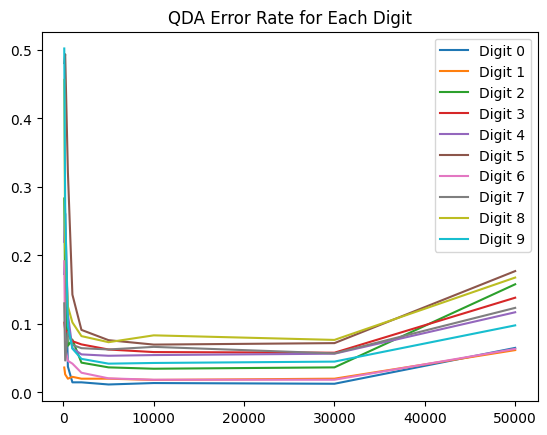

In [12]:
plt.plot([100,200,500,1000,2000,5000,10000,30000,50000],  [training_100['Digit_Errors'][1], training_200['Digit_Errors'][1],training_500['Digit_Errors'][1],training_1000['Digit_Errors'][1],training_2000['Digit_Errors'][1],training_5000['Digit_Errors'][1],training_10000['Digit_Errors'][1],training_30000['Digit_Errors'][1],training_50000['Digit_Errors'][0]], label = ['Digit 0','Digit 1', 'Digit 2', 'Digit 3', 'Digit 4', 'Digit 5', 'Digit 6', 'Digit 7', 'Digit 8', 'Digit 9'])
plt.title('QDA Error Rate for Each Digit')
plt.legend()

# Submission

In [13]:
# A code snippet to help you save your results into a kaggle accepted csv
import pandas as pd
import numpy as np

# Usage: results_to_csv(clf.predict(X_test))
def results_to_csv(y_test):
    y_test = y_test.astype(int)
    df = pd.DataFrame({'Category': y_test})
    df.index += 1 # Ensures that the index starts at 1
    df.to_csv('submission.csv', index_label='Id')


# Spam (Question 5)

In [14]:
import glob
spam_data = []
for filename in glob.glob("../data/spam/" + '*.txt'):
    with open(filename, 'r', encoding='utf-8', errors='ignore') as f:
        try:
            text = f.read() # Read in text from file
        except Exception as e:
            # skip files we have trouble reading.
            continue
        text = text.replace('\r\n', ' ')
        spam_data.append(text)

ham_data = []
for filename in glob.glob("../data/ham/" + '*.txt'):
    with open(filename, 'r', encoding='utf-8', errors='ignore') as f:
        try:
            text = f.read() # Read in text from file
        except Exception as e:
            # skip files we have trouble reading.
            continue
        text = text.replace('\r\n', ' ')
        ham_data.append(text)

df_spam = pd.DataFrame(spam_data, columns = ['data'])
df_ham = pd.DataFrame(ham_data, columns = ['data'])
df_spam['label'] = np.ones(len(spam_data))
df_ham['label'] = np.zeros(len(ham_data))
df = pd.concat([df_ham, df_spam])
df = df.reset_index(drop = True)
df.head()

,data,label
0,Subject: re : june tenaska gas file\n\ndaren :...,0.0
1,Subject: shut - in of meter 0984179 hoff helle...,0.0
2,Subject: re : correction on nom for 4 / 30 / 0...,0.0
3,Subject: re : table and buffet\n\nis it very d...,0.0
4,Subject: blue dolpin / august and september 20...,0.0


In [15]:
test_data = []
for filename in ["../data/test/" + str(x) + '.txt' for x in range(1000)]:
    with open(filename, 'r', encoding='utf-8', errors='ignore') as f:
        try:
            text = f.read() # Read in text from file
        except Exception as e:
            # skip files we have trouble reading.
            continue
        text = text.replace('\r\n', ' ')
        test_data.append(text)

For Submitting

In [16]:
import scipy
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_transformer = TfidfVectorizer(max_features=1000)

#s_data = np.load("../data/spam-data-hw3.npz")
master_spam_data = tfidf_transformer.fit_transform(df['data'])
master_test_data = tfidf_transformer.transform(test_data)
master_spam_data = master_spam_data.toarray()
master_test_data = master_test_data.toarray()

means = {}
covariances = {}
for clas in range(2):
    arg_digit = np.where(df['label'] == clas)[0]
    covariances[clas] = np.cov(master_spam_data[arg_digit], rowvar=False) 
    means[clas] = np.mean(master_spam_data[arg_digit], axis = 0)


pooled_covariance = 0
for clas in range(2):
    arg_digit = np.where(df['label'] == clas)[0]
    pooled_covariance += (covariances[clas] * len(arg_digit))

lamb = 0.000000001
pooled_covariance = pooled_covariance/len(df['label'])
pooled_covariance_changed = pooled_covariance + lamb*np.identity(len(pooled_covariance))

single_LDA = {}
for clas in range(2):
    arg_digit = np.where(df['label'] == clas)[0]
    single_LDA[clas] = scipy.stats.multivariate_normal.logpdf(x = master_test_data, mean = means[clas], cov = pooled_covariance_changed, allow_singular=True) + np.log(len(arg_digit)/len(df['label']))

f = np.array(list(single_LDA.values()))
ans = np.argmax(f, axis = 0)
results_to_csv(ans)

In [17]:
'''
import scipy
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

X_train, X_test, y_train, y_test = train_test_split(df['data'], df['label'], test_size=0.20, random_state=42)

tfidf_transformer = TfidfVectorizer(max_features=1000)
X_train_tif = tfidf_transformer.fit_transform(X_train)
X_test_tif = tfidf_transformer.transform(X_test)

X_train_tif = X_train_tif.toarray()
X_test_tif = X_test_tif.toarray()

#s_data = np.load("../data/spam-data-hw3.npz")
master_spam_data = X_train_tif

means = {}
covariances = {}
for clas in range(2):
    arg_digit = np.where(y_train == clas)[0]
    covariances[clas] = np.cov(X_train_tif[arg_digit], rowvar=False) 
    means[clas] = np.mean(X_train_tif[arg_digit], axis = 0)


pooled_covariance = 0
for clas in range(2):
    arg_digit = np.where(y_train == clas)[0]
    pooled_covariance += (covariances[clas] * len(arg_digit))

lamb = 0.000000001
pooled_covariance = pooled_covariance/len(y_train)
pooled_covariance_changed = pooled_covariance + lamb*np.identity(len(pooled_covariance))

single_LDA = {}
for clas in range(2):
    arg_digit = np.where(y_train == clas)[0]
    single_LDA[clas] = scipy.stats.multivariate_normal.logpdf(x = X_test_tif, mean = means[clas], cov = pooled_covariance_changed, allow_singular=True) + np.log(len(arg_digit)/len(y_train))

f = np.array(list(single_LDA.values()))
ans = np.argmax(f, axis = 0)
score_LDA = sum(ans == y_test)/len(y_test)
print('LDA accuracy:', score_LDA)

lamb = 0.000000001
for clas in range(2):
    covariances[clas] = covariances[clas] + lamb*np.identity(len(covariances[clas]))

single_QDA = {}
for clas in range(2):
    arg_digit = np.where(y_train == clas)[0]
    single_QDA[clas] = scipy.stats.multivariate_normal.logpdf(x = X_test_tif, mean = means[clas], cov = covariances[clas], allow_singular=True) + np.log(len(arg_digit)/len(y_train))

f_QDA = np.array(list(single_QDA.values()))
ans_QDA = np.argmax(f_QDA, axis = 0)
score_QDA = sum(ans_QDA == y_test)/len(y_test)
print('QDA accuracy:', score_QDA)
'''

'\nimport scipy\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.feature_extraction.text import TfidfVectorizer\n\nX_train, X_test, y_train, y_test = train_test_split(df[\'data\'], df[\'label\'], test_size=0.20, random_state=42)\n\ntfidf_transformer = TfidfVectorizer(max_features=1000)\nX_train_tif = tfidf_transformer.fit_transform(X_train)\nX_test_tif = tfidf_transformer.transform(X_test)\n\nX_train_tif = X_train_tif.toarray()\nX_test_tif = X_test_tif.toarray()\n\n#s_data = np.load("../data/spam-data-hw3.npz")\nmaster_spam_data = X_train_tif\n\nmeans = {}\ncovariances = {}\nfor clas in range(2):\n    arg_digit = np.where(y_train == clas)[0]\n    covariances[clas] = np.cov(X_train_tif[arg_digit], rowvar=False) \n    means[clas] = np.mean(X_train_tif[arg_digit], axis = 0)\n\n\npooled_covariance = 0\nfor clas in range(2):\n    arg_digit = np.where(y_train == clas)[0]\n    pooled_covariance += (covariances[clas] * len(arg_digit))\n\nlamb = 0.000000001\npooled_covariance

# MNIST (Question 4)

Submission

In [6]:
def PCA(X_train, X_test, n):
    
    cov_matrix = np.cov(X_train, ddof = 1, rowvar=False)
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
    order_of_importance = np.argsort(eigenvalues)[::-1] 
    sorted_eigenvalues = eigenvalues[order_of_importance]
    sorted_eigenvectors = eigenvectors[:,order_of_importance]
    explained_variance = sorted_eigenvalues / np.sum(sorted_eigenvalues)
    k = n # select the number of principal components
    reduced_data = np.matmul(X_train, sorted_eigenvectors[:,:k])
    reduced_test = np.matmul(X_test, sorted_eigenvectors[:,:k])
    return reduced_data, reduced_test
    #total_explained_variance = sum(explained_variance[:k])

In [19]:
import scipy
from sklearn.model_selection import train_test_split

data = np.load("../data/mnist-data-hw3.npz")
mnist_data = data['training_data']
master_mnist_data = mnist_data.reshape(len(mnist_data), -1)
master_mnist_data = master_mnist_data/np.linalg.norm(master_mnist_data, axis = 1, ord = 2, keepdims=True)
mnist_labels = data['training_labels']

mnist_test = data['test_data']
mnist_test = mnist_test.reshape(len(mnist_test), -1)
mnist_test = mnist_test/np.linalg.norm(mnist_test, axis = 1, ord = 2, keepdims=True)

#master_mnist_data, X_test, mnist_labels, y_test = train_test_split(master_mnist_data, data['training_labels'], test_size=0.2, random_state = 42)

#master_mnist_data = master_mnist_data[:20000]
#mnist_labels = mnist_labels[:20000]

master_mnist_data, mnist_test = PCA(master_mnist_data, mnist_test, 600)


means = {}
covariances = {}
for digit in range(0, 10):
    arg_digit = np.where(mnist_labels == digit)[0]
    covariances[digit] = np.cov(master_mnist_data[arg_digit], rowvar=False)
    means[digit] = np.mean(master_mnist_data[arg_digit], axis = 0)

lamb = 0.0008
for digit in range(10):
    covariances[digit] = covariances[digit] + lamb*np.identity(len(covariances[digit]))

multi_QDA = {}
for digit in range(10):
    arg_digit = np.where(mnist_labels == digit)[0]
    multi_QDA[digit] = scipy.stats.multivariate_normal.logpdf(x = mnist_test, mean = means[digit], cov = covariances[digit], allow_singular=True) + np.log(len(arg_digit)/len(mnist_labels))



f_QDA = np.array(list(multi_QDA.values()))
ans_QDA = np.argmax(f_QDA, axis = 0)
#QDA_score = (sum(ans_QDA == y_test)/len(y_test))
results_to_csv(ans_QDA)


/opt/homebrew/lib/python3.11/site-packages/scipy/stats/_multivariate.py:449: ComplexWarning: Casting complex values to real discards the imaginary part
  mean = np.asarray(mean, dtype=float)
/opt/homebrew/lib/python3.11/site-packages/scipy/stats/_multivariate.py:464: ComplexWarning: Casting complex values to real discards the imaginary part
  cov = np.asarray(cov, dtype=float)
/opt/homebrew/lib/python3.11/site-packages/scipy/stats/_multivariate.py:498: ComplexWarning: Casting complex values to real discards the imaginary part
  x = np.asarray(x, dtype=float)


In [26]:

import scipy
from sklearn.model_selection import train_test_split
#from sklearn.decomposition import PCA
data = np.load("../data/mnist-data-hw3.npz")
mnist_data = data['training_data']
master_mnist_data = mnist_data.reshape(len(mnist_data), -1)
master_mnist_data.shape
master_mnist_data = master_mnist_data/np.linalg.norm(master_mnist_data, axis = 1, ord = 2, keepdims=True)


def PCA_tester(lm, alpha):
    X_train, X_test, y_train, y_test = train_test_split(master_mnist_data, data['training_labels'], test_size=0.2, random_state = 20)
    X_train, X_test = PCA(X_train, X_test, 600)
    lamb = lm #0.0008

    means = {}
    covariances = {}
    for digit in range(0, 10):
        arg_digit = np.where(y_train == digit)[0]
        covariances[digit] = np.cov(X_train[arg_digit], rowvar=False)
        means[digit] = np.mean(X_train[arg_digit], axis = 0)

    #LDA
    pooled_covariance = 0
    for digit in range(0,10):
        arg_digit = np.where(y_train == digit)[0]
        pooled_covariance += (covariances[digit] * len(arg_digit))

    pooled_covariance = pooled_covariance/len(y_train)
    pooled_covariance_changed = pooled_covariance + lamb*np.identity(len(pooled_covariance))

    multi_LDA = {}
    for digit in range(10):
        arg_digit = np.where(y_train == digit)[0]
        multi_LDA[digit] = scipy.stats.multivariate_normal.logpdf(x = X_test, mean = means[digit], cov = pooled_covariance_changed, allow_singular=True) + np.log(len(arg_digit)/len(y_train))

    f_LDA = np.array(list(multi_LDA.values()))
    ans_LDA = np.argmax(f_LDA, axis = 0)
    LDA_score = sum(ans_LDA == y_test)/len(y_test)
    print('LDA accuracy is:', LDA_score)

    #QDA
    for digit in range(10):
        covariances[digit] = covariances[digit] + lamb*np.identity(len(covariances[digit]))

    multi_QDA = {}
    for digit in range(10):
        arg_digit = np.where(y_train == digit)[0]
        multi_QDA[digit] = scipy.stats.multivariate_normal.logpdf(x = X_test, mean = means[digit], cov = covariances[digit], allow_singular=True) + np.log(len(arg_digit)/len(y_train))


    f_QDA = np.array(list(multi_QDA.values()))
    ans_QDA = np.argmax(f_QDA, axis = 0)
    QDA_score = sum(ans_QDA == y_test)/len(y_test)
    print('QDA accuracy is:', QDA_score)

    #RDA
    rda_cov = {}
    for digit in range(10):
        rda_cov[digit] = alpha*covariances[digit] + (1 - alpha)*pooled_covariance_changed

    multi_RDA = {}
    for digit in range(10):
        arg_digit = np.where(y_train == digit)[0]
        multi_RDA[digit] = scipy.stats.multivariate_normal.logpdf(x = X_test, mean = means[digit], cov = rda_cov[digit], allow_singular=True) + np.log(len(arg_digit)/len(y_train))


    f_RDA = np.array(list(multi_RDA.values()))
    ans_RDA = np.argmax(f_RDA, axis = 0)
    RDA_score = sum(ans_RDA == y_test)/len(y_test)
    print('RDA accuracy is:', RDA_score)

In [31]:
PCA_tester(0.0008, 0.6)

LDA accuracy is: 0.8846666666666667
QDA accuracy is: 0.95625
RDA accuracy is: 0.94225
